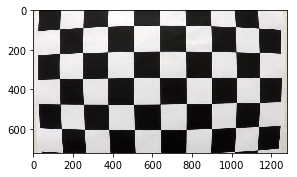

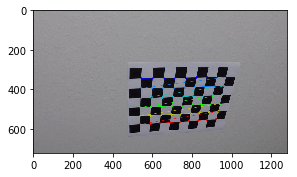

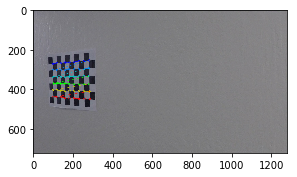

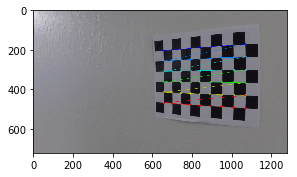

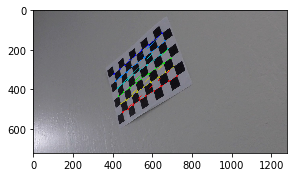

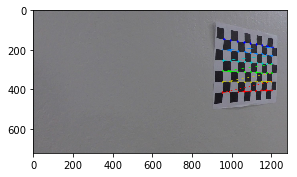

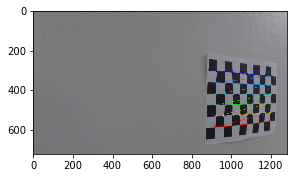

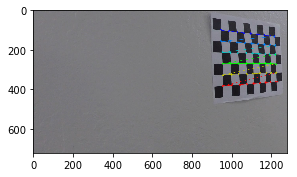

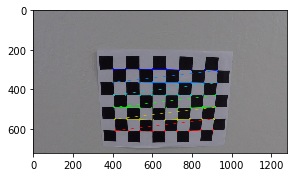

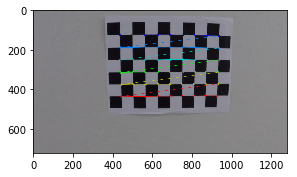

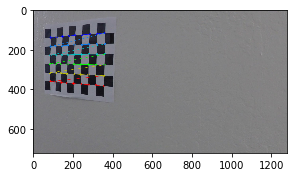

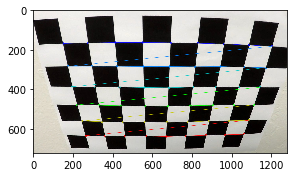

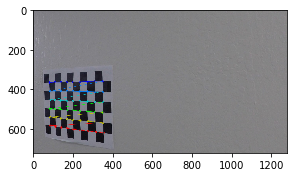

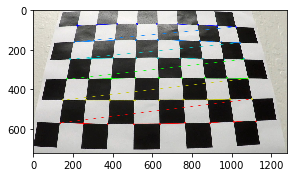

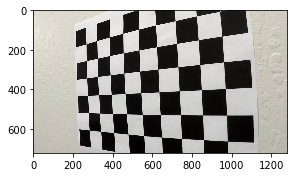

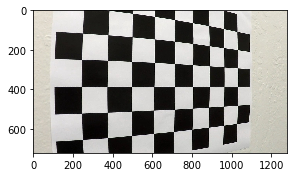

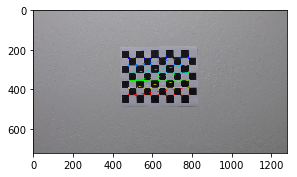

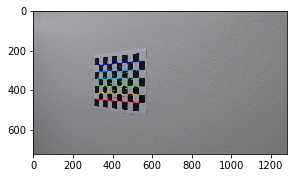

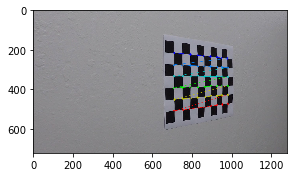

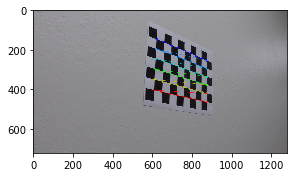

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

global left_fit
global right_fit
first_frame = False

left_fit = []
right_fit = []
    
## calibrate camera using chessboard pictures
images= glob.glob('./camera_cal/calibration*.jpg')
nx=9
ny=6

#Arrays to store object and image points from all the images

objpoints = []  # 3D points in real world space
imagepoints = [] # 3D points in image plane

## Initialize
objp = np.zeros((ny*nx,3),np.float32)

## generate x y coordinates
objp [:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for fname in images:
    ## Read each image
    img = mpimg.imread(fname)
    #plt.imshow(img)

    ##Converting the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ##Finding chessboard corners (for an 9x6 board) for grayscale image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    ## If corners are found, add object points, image points
    if ret == True:
        imagepoints.append(corners)
        objpoints.append(objp)

        ## draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    #plt.clf()
    #plt.imshow(img)
    
    plt.figure(figsize=(10,40))
    plt.subplot(121)
    plt.imshow(img)

##Camera calibration, given object points, image points, and the shape of the grayscale image
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imagepoints, gray.shape[::-1], None, None)

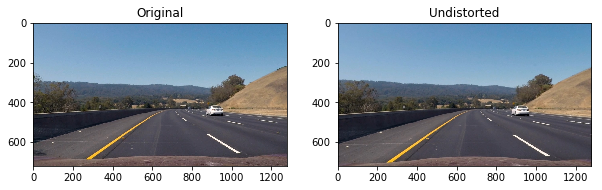

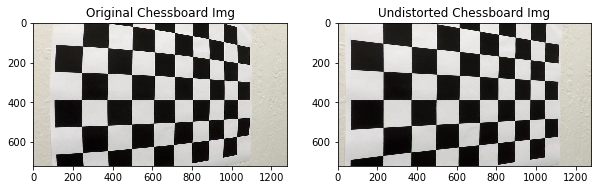

In [2]:
test_image = plt.imread('./test_images/test3.jpg')
cam_image = plt.imread('./camera_cal/calibration5.jpg')
undist = cv2.undistort(test_image, mtx, dist, None, mtx)
camundist = cv2.undistort(cam_image, mtx, dist, None, mtx)
plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(test_image)
plt.title('Original')
plt.subplot(122)
plt.imshow(undist)
plt.title('Undistorted')
plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(cam_image)
plt.title('Original Chessboard Img')
plt.subplot(122)
plt.imshow(camundist)
plt.title('Undistorted Chessboard Img')


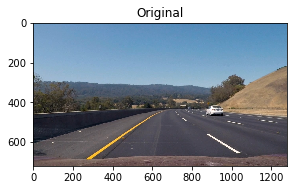

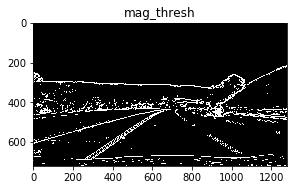

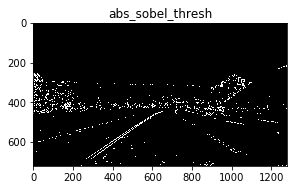

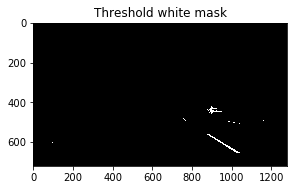

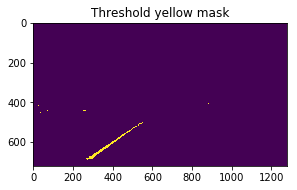

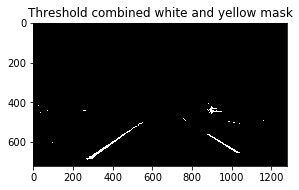

In [3]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=9, mag_thresh=(20, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, sobel_kernel=9, orient='x', thresh_min=20, thresh_max=100):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def thresholdImage(img, color):
    img = np.copy(img)
    
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    
    ## White Color
    minwhite = np.array([0,220,0], dtype=np.uint8)
    maxwhite = np.array([255,255,255], dtype=np.uint8)
    whiteMask = cv2.inRange(hls, minwhite, maxwhite)

    ## Yellow Color as some lanes are yellow, which cannot be detected by just white mask
    minyellow = np.array([20,0,120], dtype=np.uint8)
    maxyellow = np.array([30,220,255], dtype=np.uint8)
    yellowMask = cv2.inRange(hls, minyellow, maxyellow)  

    combined_binary = np.zeros_like(whiteMask)
    
    if color == 'w':
        combined_binary[(whiteMask == 255)] = 255
        combined_binary[(combined_binary == 255)] = 1    
    if color == 'y':
        combined_binary[(yellowMask == 255)] = 255
        combined_binary[(combined_binary == 255)] = 1
    if color == 'b':
        combined_binary[((whiteMask == 255) | (yellowMask == 255))] = 255
        combined_binary[(combined_binary == 255)] = 1
    return combined_binary
    
plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(test_image)
plt.title('Original')

plt.figure(figsize=(10,40))
plt.subplot(121)
magThresImage = mag_thresh(test_image)
plt.imshow(magThresImage, cmap='gray')
plt.title('mag_thresh')

plt.figure(figsize=(10,40))
plt.subplot(121)
absSobelThres = abs_sobel_thresh(test_image)
plt.imshow(absSobelThres, cmap='gray')
plt.title('abs_sobel_thresh')

plt.figure(figsize=(10,40))
plt.subplot(121)
thresImageW = thresholdImage(test_image, 'w')
plt.imshow(thresImageW, cmap='gray')
plt.title('Threshold white mask')

plt.figure(figsize=(10,40))
plt.subplot(121)
thresImageY = thresholdImage(test_image, 'y')
plt.imshow(thresImageY)
plt.title('Threshold yellow mask')

plt.figure(figsize=(10,40))
plt.subplot(121)
thresImage = thresholdImage(test_image, 'b')
plt.imshow(thresImage, cmap='gray')
plt.title('Threshold combined white and yellow mask')




(1280, 720)
[[  585.           460.        ]
 [  203.33332825   720.        ]
 [ 1126.66662598   720.        ]
 [  695.           460.        ]]
[[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


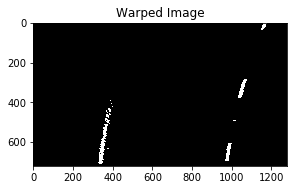

In [4]:
img_size = (thresImage.shape[1], thresImage.shape[0])
print (img_size)
width, height = img_size
offset = 200
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst, src)

print (src)
print (dst)

plt.figure(figsize=(10,40))
plt.subplot(121)
binary_warped = cv2.warpPerspective(thresImage,M, (width, height))
plt.imshow(binary_warped, cmap='gray')
plt.title('Warped Image')

In [5]:

def pipeline(img):

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    global out_img
    global first_frame

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    histogram = np.sum(binary_warped[:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)

    # Number of sliding windows
    nwindows = 9

    # Height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Margin in which to search
    margin = 100

    # Minimum number of pixels found to recenter window
    minpix = 50

    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    if not first_frame:
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        histogram = np.sum(binary_warped[:,:], axis=0)
        margin = 100
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(9):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        first_frame = True
        last_fitx = (left_fitx,right_fitx)

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        plt.figure(figsize=(10,40))
        plt.subplot(121)
        plt.imshow(out_img)
        plt.xlim(0, 1280)
        plt.ylim(720, 0)     
        
        ## RADIUS OF CURVATURE
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        y_eval = 700
        midx = 650

        y_eval = np.max(ploty)
        left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        print(left_curverad, right_curverad)

        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 

        # Combine the result with the original image
        result1 = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

        cv2.putText(result1,'Radius of Curvature: %.2fm' % left_curverad,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

        left_pixX = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
        right_pixX = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
        position_from_center = ((left_pixX + right_pixX)/2 - midx) * xm_per_pix
        if position_from_center < 0:
            text = 'left'
        else:
            text = 'right'
        cv2.putText(result1,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        plt.figure(figsize=(40,80))
        plt.subplot(121)
        plt.imshow(result1)
        
    else:

        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100

        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)    

    return result



2361.59232819 2724.92022948
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [01:48<00:00, 11.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 1min 50s


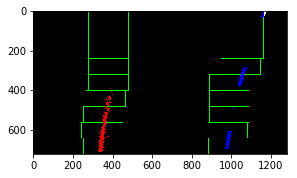

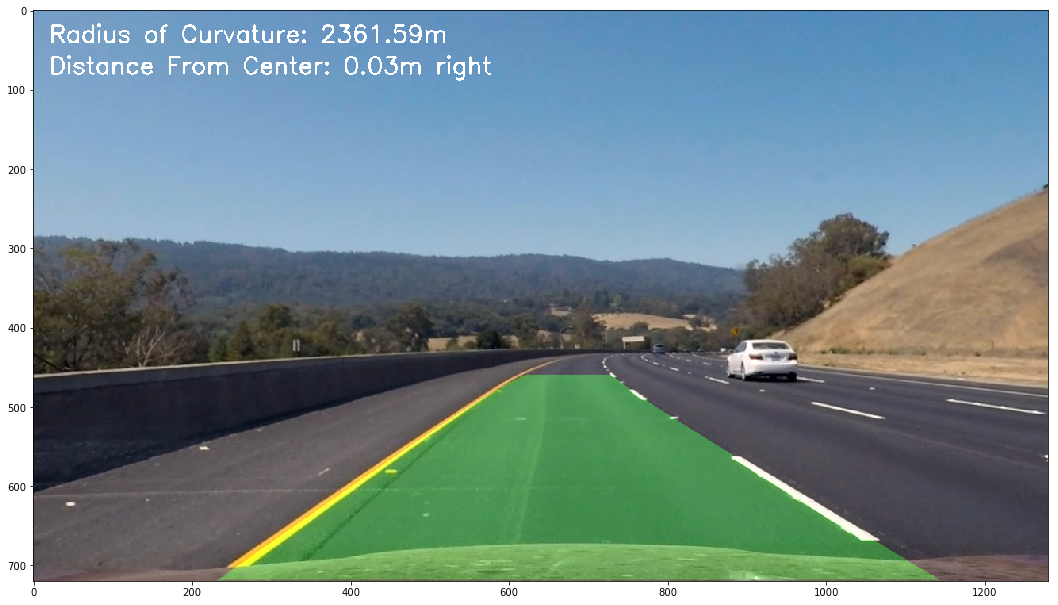

In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(video_output, audio=False)

HTML("""<video width="960" height="540" controls>  <source src="{0}"></video>""".format(video_output))